# Assignment #4
#### Problem #1  (To be submitted individually)

Using any two or several clustering techniques we have covered in class – determine the groups of “similar” panelist.  You will choose what set of attributes to use for determining similarity-explain why you chose them.  Provide the evaluation and validation of the produced model(s).  Describe in detail how you prepared the data, created the training data set, designed features and trained the model (what options, parameters, number of clusters, types of clustering techniques(s) used, etc.).  Compare the models produced. 


In [1]:
import h5py as h5
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, LinearSVR
from sklearn import preprocessing
import calendar as cal
import seaborn as sns
import datetime as dt
%matplotlib inline

# Geographic Information Study

1) Confirm the data in metric

2) Decide whether to scale or standardize the data

3) Decide which variables to use for clustering

4) Define similarity or dissimilarity measures between observations

5) Visualize Individual Attributes and Pair-wise Distances between the Observations

6) Select the clustering method to use and decide how many clusters to have

7) Profile and interpret the clusters

8) Assess the robustness of our clusters

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from pandas import HDFStore
store = HDFStore('/Users/ryanriopelle/Documents/DSE/DSE220/yogurt.h5')
store.keys()

['/delivery_stores', '/demos', '/drug', '/groc', '/panel']

In [4]:
# We are storing the data in an HDF5 file, this makes it easy to access
path='/Users/ryanriopelle/Documents/DSE/DSE220/yogurt.h5'
data = h5.File(path)
def printname(name):   
    print(name)
data.visit(printname)

delivery_stores
delivery_stores/axis0
delivery_stores/axis1
delivery_stores/block0_items
delivery_stores/block0_values
delivery_stores/block1_items
delivery_stores/block1_values
delivery_stores/block2_items
delivery_stores/block2_values
demos
demos/axis0
demos/axis1
demos/block0_items
demos/block0_values
demos/block1_items
demos/block1_values
demos/block2_items
demos/block2_values
drug
drug/_i_table
drug/_i_table/index
drug/_i_table/index/abounds
drug/_i_table/index/bounds
drug/_i_table/index/indices
drug/_i_table/index/indicesLR
drug/_i_table/index/mbounds
drug/_i_table/index/mranges
drug/_i_table/index/ranges
drug/_i_table/index/sorted
drug/_i_table/index/sortedLR
drug/_i_table/index/zbounds
drug/table
groc
groc/_i_table
groc/_i_table/index
groc/_i_table/index/abounds
groc/_i_table/index/bounds
groc/_i_table/index/indices
groc/_i_table/index/indicesLR
groc/_i_table/index/mbounds
groc/_i_table/index/mranges
groc/_i_table/index/ranges
groc/_i_table/index/sorted
groc/_i_table/index/sort

In [5]:
# List is the graphic data keys so that non metric data can be used
df_drug_sales = pd.read_hdf(path, key='drug')
df_drug_sales.keys()

Index([u'IRI_KEY', u'WEEK', u'SY', u'GE', u'VEND', u'ITEM', u'UNITS',
       u'DOLLARS', u'F', u'D', u'PR', u'file', u'year_int'],
      dtype='object')

In [6]:
df_stores = pd.read_hdf(path, key='delivery_stores')
df_stores.keys()

Index([u'IRI_KEY', u'OU', u'EST_ACV', u'Market_Name', u'Open', u'Clsd',
       u'yearid', u'year', u'name'],
      dtype='object')

# Investigating The Data : Data Preview of Drug Store Sales and Stores

In [7]:
df_drug_sales.head()

,IRI_KEY,WEEK,SY,GE,VEND,ITEM,UNITS,DOLLARS,F,D,PR,file,year_int
0,8042577,1133,0,1,70470,300,2,1.78,NONE,0,0,yogurt_drug_1114_1165,1
1,8042577,1134,0,1,70470,300,1,0.89,NONE,0,0,yogurt_drug_1114_1165,1
2,8042577,1135,0,1,70470,300,1,0.89,NONE,0,0,yogurt_drug_1114_1165,1
3,8042577,1136,0,1,70470,313,1,0.89,NONE,0,0,yogurt_drug_1114_1165,1
4,8042577,1137,0,1,70470,300,2,1.78,NONE,0,0,yogurt_drug_1114_1165,1


In [8]:
df_stores.head()

,IRI_KEY,OU,EST_ACV,Market_Name,Open,Clsd,yearid,year,name
0,200039,GR,9.602997,BUFFALO/ROCHESTER,539,1219,1,2001,107
1,200171,GR,28.454990,MILWAUKEE,522,9998,1,2001,118
2,200197,GR,11.314990,PEORIA/SPRINGFLD.,903,9998,1,2001,75
3,200233,GR,7.473000,OKLAHOMA CITY,1122,1150,1,2001,123
4,200272,GR,13.266000,LOS ANGELES,873,9998,1,2001,150


# General Summary of Stores Expected ACV

In [9]:
sumSales=df_stores.groupby(['Market_Name']).sum()
sumSales.loc[:,['EST_ACV','Open','Clsd']].head()

,EST_ACV,Open,Clsd
Market_Name,,,
ATLANTA,8642.440204,501124,4320069
BIRMINGHAM/MONTG.,5757.294440,409922,2916059
BOSTON,18226.274402,635510,6064396
BUFFALO/ROCHESTER,9834.588446,319867,3075407
CHARLOTTE,6991.051695,446643,3662522


In [10]:
Top_EST_ACV=sumSales.loc[:,['EST_ACV','Open','Clsd']].sort(['EST_ACV'])
Top_EST_ACV.head()

,EST_ACV,Open,Clsd
Market_Name,,,
OKLAHOMA CITY,1086.258733,92866,928734
"TULSA,OK",1099.528776,123166,943534
GREEN BAY,2133.134390,107004,860948
SPOKANE,2379.727185,138595,1112177
EAU CLAIRE,2748.626317,84272,865059


In [11]:
Top_EST_ACV

,EST_ACV,Open,Clsd
Market_Name,,,
OKLAHOMA CITY,1086.258733,92866,928734
"TULSA,OK",1099.528776,123166,943534
GREEN BAY,2133.134390,107004,860948
SPOKANE,2379.727185,138595,1112177
EAU CLAIRE,2748.626317,84272,865059
DES MOINES,2971.078996,110802,1126279
SALT LAKE CITY,3175.396988,119005,1446011
PITTSFIELD,3200.094835,110326,1383272
MISSISSIPPI,3421.561035,267936,1799915


In [12]:
Top_EST_ACV['Sales_Per_Store']=Top_EST_ACV.EST_ACV/Top_EST_ACV.Open
Top_EST_ACV.head()

,EST_ACV,Open,Clsd,Sales_Per_Store
Market_Name,,,,
OKLAHOMA CITY,1086.258733,92866,928734,0.011697
"TULSA,OK",1099.528776,123166,943534,0.008927
GREEN BAY,2133.134390,107004,860948,0.019935
SPOKANE,2379.727185,138595,1112177,0.017170
EAU CLAIRE,2748.626317,84272,865059,0.032616


# Merge Data From Drug Stores (drug) and Location Info (delivery_stores )

Drug_Sales: 

Index([u'IRI_KEY', u'WEEK', u'SY', u'GE', u'VEND', u'ITEM', u'UNITS',
       u'DOLLARS', u'F', u'D', u'PR', u'file', u'year_int'],
      dtype='object')

Index([u'IRI_KEY', u'OU', u'EST_ACV', u'Market_Name', u'Open', u'Clsd',
       u'yearid', u'year', u'name'],
      dtype='object')

Specific columns of dollars and units can be pulled out and summarized, and grouped according to geographic area, time frames, and items.

### Process Steps

1) Join week number with week times

2) Summarize according to product

3) Summarize according to time, weeks, months, years

4) Join dataframes with stores dataframe and summarize over market

5) Split data into 5 or 6 geographic locations

6) Compare top sales across 5 or 6 locations

7) PCA Analysis over time frames at each location


# Reclculate using week of the year, and redo during averages

In [13]:
# Imoport drug_sales
df_drug_sales = pd.read_hdf(path, key='drug')

# Import week converion
weeks = pd.read_csv('IRI week translation.csv')

# Join with weeks
df_drug_sales=pd.merge(df_drug_sales, weeks, how='inner', left_on='WEEK', right_on='IRI Week')

# Select specific columns
df_drug_sales= df_drug_sales[['IRI_KEY','VEND', 'ITEM', 'UNITS','DOLLARS', 
                             'Calendar week starting on', 'Calendar week ending on',
                            'WeekOfYear','Month', 'Year']]
# Preview the sales dataframe
df_drug_sales.head()

,IRI_KEY,VEND,ITEM,UNITS,DOLLARS,Calendar week starting on,Calendar week ending on,WeekOfYear,Month,Year
0,8042577,70470,300,2,1.78,14-May-01,20-May-01,20,5,2001
1,8044648,78255,429,2,1.18,14-May-01,20-May-01,20,5,2001
2,8041920,9426,43,2,1.78,14-May-01,20-May-01,20,5,2001
3,8041920,9426,51,1,0.89,14-May-01,20-May-01,20,5,2001
4,8041920,70470,300,4,3.56,14-May-01,20-May-01,20,5,2001


# Sample Data For A Single Store Can Be Viewed

In [14]:
weeks

,IRI Week,Calendar week starting on,Calendar week ending on,WeekOfYear,Month,Year
0,1114,1-Jan-01,7-Jan-01,1,1,2001
1,1115,8-Jan-01,14-Jan-01,2,1,2001
2,1116,15-Jan-01,21-Jan-01,3,1,2001
3,1117,22-Jan-01,28-Jan-01,4,1,2001
4,1118,29-Jan-01,4-Feb-01,5,1,2001
5,1119,5-Feb-01,11-Feb-01,6,2,2001
6,1120,12-Feb-01,18-Feb-01,7,2,2001
7,1121,19-Feb-01,25-Feb-01,8,2,2001
8,1122,26-Feb-01,4-Mar-01,9,2,2001
9,1123,5-Mar-01,11-Mar-01,10,3,2001


In [15]:
df_drug_sales.loc[df_drug_sales['IRI_KEY'] == 8042577].head()

,IRI_KEY,VEND,ITEM,UNITS,DOLLARS,Calendar week starting on,Calendar week ending on,WeekOfYear,Month,Year
0,8042577,70470,300,2,1.78,14-May-01,20-May-01,20,5,2001
362,8042577,70470,300,1,0.89,21-May-01,27-May-01,21,5,2001
727,8042577,70470,300,1,0.89,28-May-01,3-Jun-01,22,5,2001
1109,8042577,70470,313,1,0.89,4-Jun-01,10-Jun-01,23,6,2001
1485,8042577,70470,300,2,1.78,11-Jun-01,17-Jun-01,24,6,2001


# Total Sales By Year

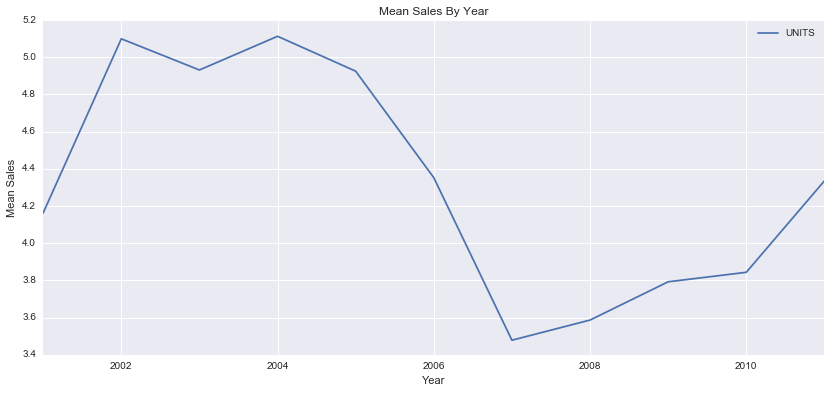

In [16]:
Sales_By_Year = df_drug_sales.groupby(['Year']).mean()[['UNITS']]
Sales_By_Year.plot(figsize=(14, 6))
plt.xlabel('Year')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Year')
plt.grid(True)
plt.show()

# Check Number of Stores To See If the Number of Stores Being Checked Has Changed.  This does not correspond with the average above which is good, in general the number of stores being monitered has been relatively consistent.

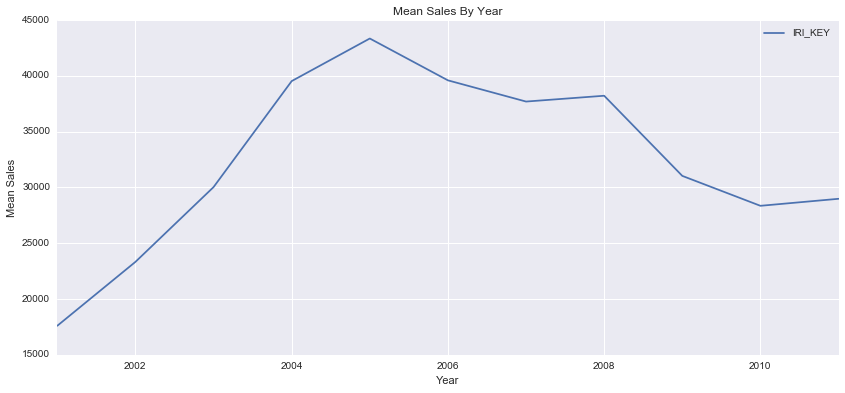

In [17]:
Sales_By_Year = df_drug_sales.groupby(['Year']).count()[['IRI_KEY']]
Sales_By_Year.plot(figsize=(14, 6))
plt.xlabel('Year')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Year')
plt.grid(True)
plt.show()

# Total Sales By Month

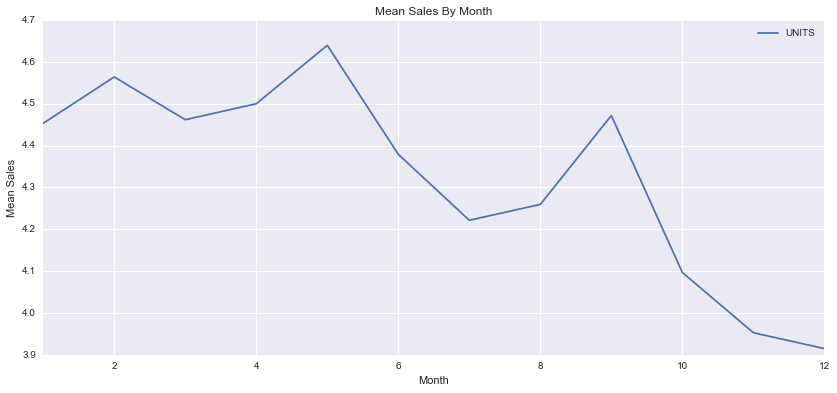

In [69]:
Sales_By_Month = df_drug_sales.groupby(['Month']).mean()[['UNITS']]
Sales_By_Month.plot(figsize=(14, 6))
plt.xlabel('Month')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Month')
plt.grid(True)
plt.show()

# Total Sales By Weeks

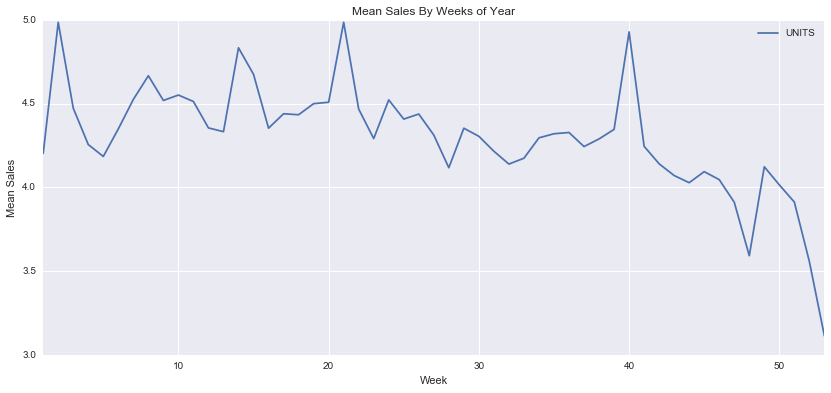

In [70]:
Sales_By_Weeks = df_drug_sales.groupby(['WeekOfYear']).mean()[['UNITS']]
Sales_By_Weeks.plot(figsize=(14, 6))
plt.xlabel('Week')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Weeks of Year')
plt.grid(True)
plt.show()

# We need to check the number of data points to make sure that none of the trends are due to missing data, we see that the amount of data is fairly consistent accept for the drop in the end

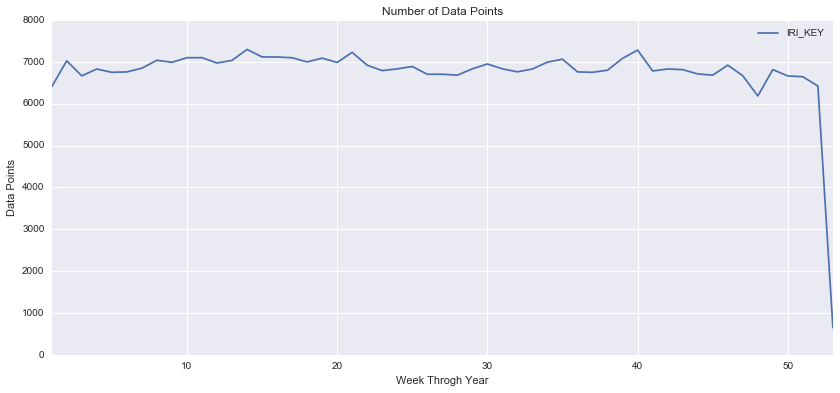

In [74]:
Data_Points_By_Weeks = df_drug_sales.groupby(['WeekOfYear']).count()[['IRI_KEY']]
Data_Points_By_Weeks.plot(figsize=(14, 6))
plt.xlabel('Week Throgh Year')
plt.ylabel('Data Points')
plt.title('Number of Data Points')
plt.grid(True)
plt.show()

# Join With Geographic Information

In [20]:
# Join Drug Store Sales With Store Geographic Information
drug_sales_geo = pd.merge(df_drug_sales,df_stores, on='IRI_KEY' )

#Select specific columns that we want to observe
drug_sales_geo = drug_sales_geo[['IRI_KEY', 'VEND', 'ITEM', 'UNITS', 'DOLLARS', u'EST_ACV', u'Market_Name',
       u'Month', u'Year','WeekOfYear', u'name','Calendar week starting on', 'Calendar week ending on']]

drug_sales_geo.head()

,IRI_KEY,VEND,ITEM,UNITS,DOLLARS,EST_ACV,Market_Name,Month,Year,WeekOfYear,name,Calendar week starting on,Calendar week ending on
0,8042577,70470,300,2,1.78,3.664000,LOS ANGELES,5,2001,20,106,14-May-01,20-May-01
1,8042577,70470,300,2,1.78,3.584000,LOS ANGELES,5,2001,20,106,14-May-01,20-May-01
2,8042577,70470,300,2,1.78,3.584000,LOS ANGELES,5,2001,20,106,14-May-01,20-May-01
3,8042577,70470,300,2,1.78,3.192999,LOS ANGELES,5,2001,20,106,14-May-01,20-May-01
4,8042577,70470,300,2,1.78,3.192999,LOS ANGELES,5,2001,20,106,14-May-01,20-May-01


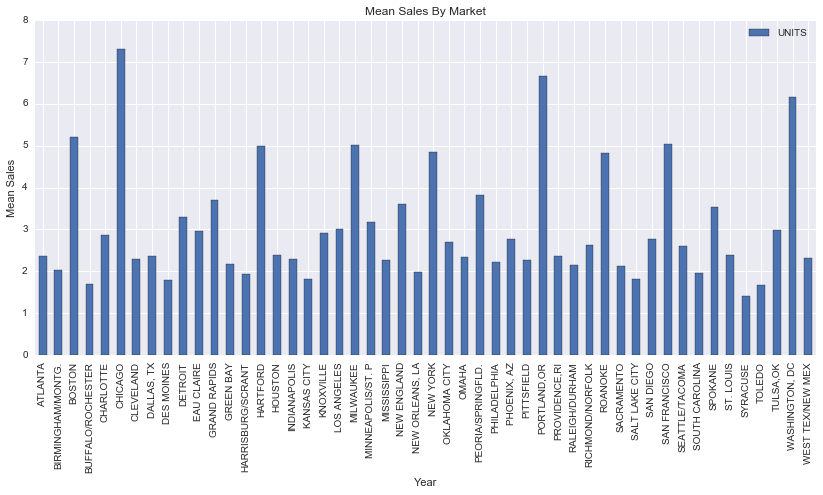

In [21]:
Sales_By_Market = drug_sales_geo.groupby(['Market_Name']).mean()[['UNITS']]
Sales_By_Market.plot(kind='bar',figsize=(14, 6), fontsize=10, sort_columns=True)
plt.xlabel('Year')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Market')

In [22]:
market_name_state = df_stores[['Market_Name']].drop_duplicates()
len (market_name_state)

50

In [23]:
# Read in census data
census_data = pd.read_csv('2010_Census_Data.csv')

#Read in csv for linking state to market area
state_link = pd.read_csv('Market_Areas_States.csv')

#Join regions with census population data
market_area_info = pd.merge(state_link,census_data, left_on='State', right_on='State Abbrev')

#Select specific columns that are wanted
market_area_info = market_area_info[['Market_Area', 'State', 'States','Region',
        'Population']]

#Display sample of the dataframe
market_area_info.head()

,Market_Area,State,States,Region,Population
0,BUFFALO/ROCHESTER,NY,Montana,West,990643
1,NEW YORK,NY,Montana,West,990643
2,SYRACUSE,NY,Montana,West,990643
3,MILWAUKEE,WI,Wisconsin,Midwest,5690204
4,GREEN BAY,WI,Wisconsin,Midwest,5690204


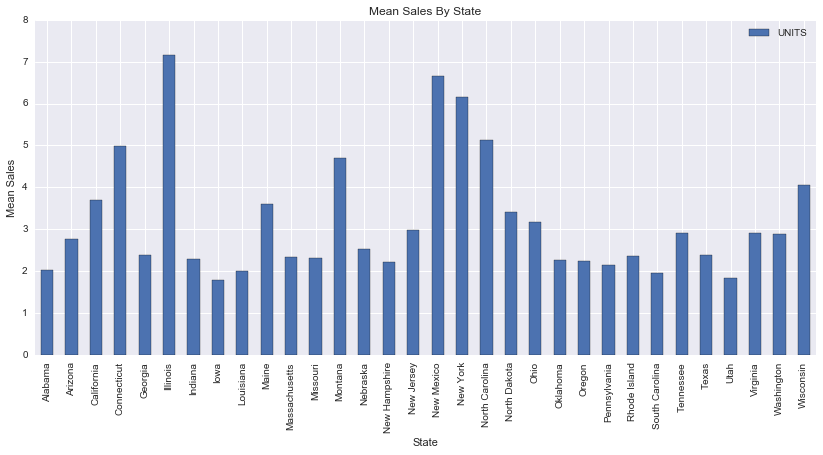

In [24]:
# Combined drug sales regions with state information
drug_sales_regions = pd.merge(drug_sales_geo, market_area_info, left_on = 'Market_Name', right_on= 'Market_Area')

# Group By Region
Sales_By_State = drug_sales_regions.groupby(['States']).mean()[['UNITS']]
Sales_By_State.plot(kind='bar',figsize=(14, 6), fontsize=10, sort_columns=True)
plt.xlabel('State')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By State')


In [25]:
len(Sales_By_State)

32

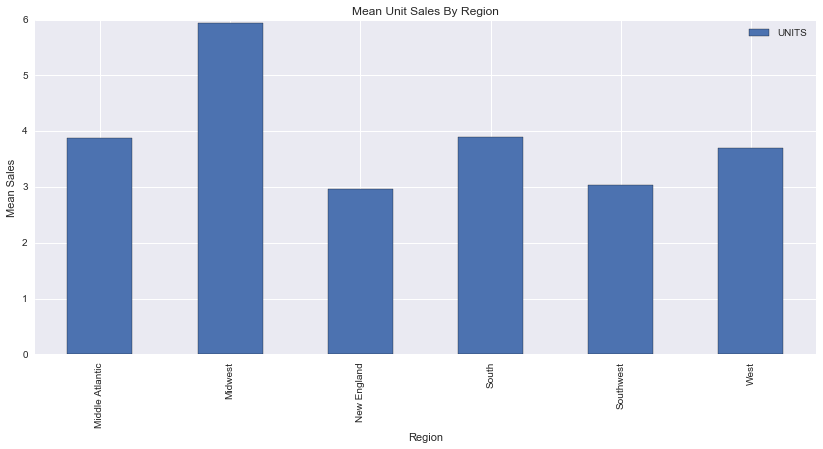

In [26]:
# Group By Region
Sales_By_Region = drug_sales_regions.groupby(['Region']).mean()[['UNITS']]
Sales_By_Region.plot(kind='bar',figsize=(14, 6), fontsize=10, sort_columns=True)
plt.xlabel('Region')
plt.ylabel('Mean Sales')
plt.title('Mean Unit Sales By Region')

# Here we tried to add dollars per capita, but it looks as though the sample areas are not equivalent to the entire state, therefore we cannot compare state population with the dollars for each area

In [27]:
Average_Sold_Per_State = drug_sales_regions.groupby(['States']).mean()[['UNITS']]
Pop = drug_sales_regions.groupby(['States']).mean()[['Population']]
Average_Units_Per_Pop = pd.DataFrame(Average_Sold_Per_State.UNITS/Pop.Population)
Average_Units_Per_Pop.columns = ['Units_Per_Pop']
Average_Units_Per_Pop.sort_values('Units_Per_Pop').values[0]

array([  9.38795173e-08])

# Below we normalize the data.  While this graph below is interesting, it does not give us concrete evidence of anything, since we can not directly correlate the population with the number of poeple entering to store for sales.  Since Montana, North Dakota, and New Mexico have the highest sales per capita, all three of these states have a limited population.  This would suggest that simply dividing by the each areas population shows may not be the best way to analyze the data. 

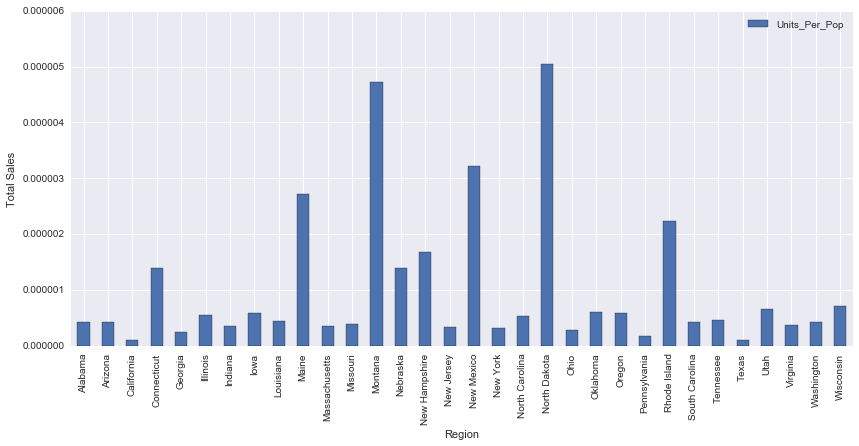

In [28]:
Units_Per_Capita=Average_Units_Per_Pop[['Units_Per_Pop']]
Units_Per_Capita.plot(kind='bar',figsize=(14, 6), fontsize=10, sort_columns=True)
plt.xlabel('Region')
plt.ylabel('Total Sales')

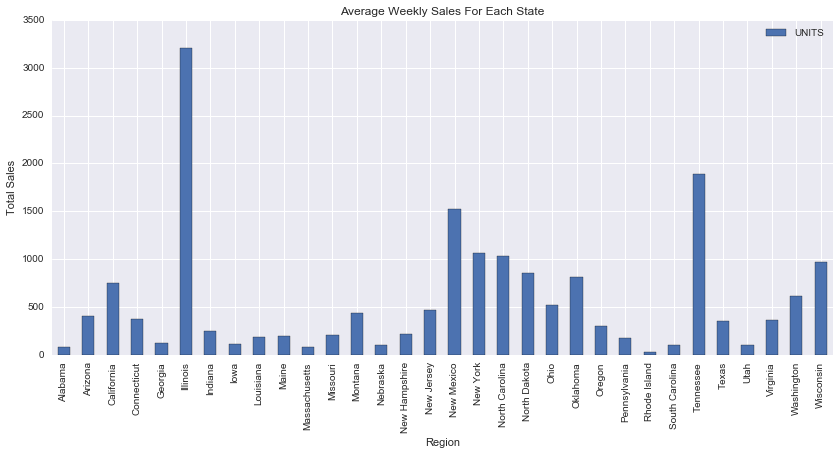

In [77]:
# store, state, sum of yogurts, mean
total_week_sales_store = drug_sales_regions.groupby(['IRI_KEY', 'WeekOfYear']).sum()
# pd.merge(total_week_sales_store,market_area_info, on='IRI_KEY')

#IRI State Link
iri_state_link=pd.merge(drug_sales_geo[['IRI_KEY','Market_Name']],market_area_info, left_on='Market_Name',right_on='Market_Area' )[['IRI_KEY','States']].drop_duplicates()

iri_state_link.set_index(['IRI_KEY'])
total_week_sales_store.reset_index(inplace=True)

# #Remerge with state after grouping
avg_weekly_sales_store = pd.merge(total_week_sales_store, iri_state_link, on='IRI_KEY' )

# #group by state to obtain average weekly sales of yogurt for stores by state
avg_weekly_sales_store = avg_weekly_sales_store.groupby(['States']).mean()[['UNITS']]

#Graphing the on average the total amount of yogurt sold per week for a store in each state
avg_weekly_sales_store.plot(kind='bar',figsize=(14, 6), fontsize=10, sort_columns=True)
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.title('Average Weekly Sales For Each State')

# Here we want to check to see if units over population would work by specifically dividing average 

# Similiarly we can do a cross tab for years, 2001 through 2011.  

In [31]:
Year_StoreSale_xtab = pd.crosstab(df_drug_sales.Year, df_drug_sales.WeekOfYear,values=df_drug_sales.UNITS, margins=True, aggfunc=sum)
Year_StoreSale_xtab 

WeekOfYear,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,All
Year,,,,,,,,,,,,,,,,,,,,,
2001,3922.0,1104.0,1139.0,1243.0,1292.0,1367.0,1422.0,1541.0,1332.0,1224.0,...,1080.0,1109.0,1032.0,1113.0,1004.0,1014.0,1049.0,850.0,NaN,73284.0
2002,3436.0,3253.0,2213.0,2123.0,1913.0,2123.0,2296.0,1959.0,2160.0,2209.0,...,2330.0,2447.0,2176.0,1444.0,2128.0,2084.0,2295.0,1652.0,NaN,118946.0
2003,2768.0,3552.0,2313.0,2125.0,2404.0,2556.0,2675.0,2587.0,2861.0,2599.0,...,3109.0,3197.0,2960.0,2424.0,3184.0,3262.0,3038.0,2386.0,NaN,148080.0
2004,3000.0,6454.0,3858.0,3438.0,3259.0,3499.0,4356.0,5992.0,3691.0,4196.0,...,3420.0,3517.0,3057.0,2669.0,3859.0,3463.0,3563.0,3086.0,NaN,202073.0
2005,3433.0,4650.0,4003.0,4006.0,3917.0,3757.0,4363.0,4557.0,4475.0,4396.0,...,3567.0,3466.0,3532.0,2534.0,3831.0,3363.0,3308.0,2715.0,NaN,213451.0
2006,NaN,3605.0,4404.0,4263.0,3471.0,3509.0,4080.0,4203.0,4506.0,4954.0,...,2148.0,2317.0,2307.0,1864.0,2284.0,2144.0,2249.0,2052.0,2014.0,172315.0
2007,5037.0,2604.0,2582.0,2464.0,2532.0,2706.0,2263.0,2521.0,2540.0,2658.0,...,2273.0,2704.0,1859.0,2389.0,2198.0,2284.0,2060.0,2164.0,NaN,131109.0
2008,1866.0,2933.0,2813.0,2881.0,3000.0,3126.0,2883.0,2868.0,3108.0,3059.0,...,2311.0,2219.0,2226.0,1929.0,2441.0,2283.0,2152.0,1967.0,NaN,137061.0
2009,1693.0,2632.0,2397.0,2565.0,2472.0,2503.0,2691.0,2476.0,2620.0,2695.0,...,2075.0,1944.0,1853.0,1561.0,1955.0,1817.0,1798.0,1569.0,NaN,117688.0


# Next would like to run PCA on the weekly data across stores to see what the eigenvalues might be able to tell us about monthly trends in the data

In [32]:
Weeks_StoreSale_xtab = pd.crosstab(df_drug_sales.IRI_KEY, df_drug_sales.WeekOfYear,values=df_drug_sales.UNITS, margins=True, aggfunc=sum)
Weeks_StoreSale_xtab.shape
Weeks_StoreSale_xtab

WeekOfYear,1,2,3,4,5,6,7,8,9,10,...,45,46,47,48,49,50,51,52,53,All
IRI_KEY,,,,,,,,,,,,,,,,,,,,,
235186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,2.0,NaN,6.0
235547,14.0,28.0,19.0,26.0,20.0,18.0,28.0,14.0,20.0,28.0,...,46.0,37.0,27.0,29.0,41.0,54.0,16.0,39.0,NaN,1657.0
237196,2.0,12.0,18.0,20.0,13.0,5.0,19.0,2.0,10.0,11.0,...,8.0,1.0,11.0,4.0,4.0,10.0,8.0,2.0,1.0,486.0
240276,14.0,58.0,44.0,50.0,41.0,29.0,55.0,43.0,55.0,40.0,...,50.0,77.0,64.0,78.0,74.0,38.0,42.0,70.0,NaN,3126.0
256498,204.0,164.0,113.0,124.0,112.0,139.0,157.0,150.0,128.0,144.0,...,119.0,146.0,121.0,115.0,182.0,130.0,170.0,116.0,10.0,7466.0
263037,1177.0,1518.0,1279.0,1491.0,1335.0,1328.0,1346.0,1485.0,1382.0,1439.0,...,1446.0,1584.0,1585.0,1386.0,1770.0,1533.0,1489.0,1306.0,102.0,76665.0
266398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0
271044,40.0,26.0,35.0,66.0,38.0,50.0,51.0,50.0,62.0,46.0,...,53.0,34.0,58.0,27.0,58.0,89.0,50.0,60.0,NaN,2184.0
271404,217.0,281.0,373.0,376.0,251.0,296.0,305.0,401.0,312.0,444.0,...,178.0,176.0,174.0,85.0,171.0,111.0,114.0,99.0,NaN,13707.0


# We need to find a way to deal with the Null values

# In order to the get the Eigenvalues, we get covariance matrix 

In [33]:
# fill null values with zero's 0.  
Weeks_StoreSale_xtab_NA = Weeks_StoreSale_xtab.fillna(value=0).transpose()

#compute the covariance matrix on the crosstab weeks_storeSale_xtab
cov_mat = np.cov(Weeks_StoreSale_xtab_NA.values)

#get the eigvalues and eig_vectors
eig_val_cov, eig_vec_cov = np.linalg.eig(cov_mat)

In [34]:
print cov_mat.shape
print eig_val_cov.shape

(54, 54)
(54,)


In [35]:
colum_names = Weeks_StoreSale_xtab.columns

In [36]:
new= pd.DataFrame(eig_vec_cov)
new.columns =colum_names

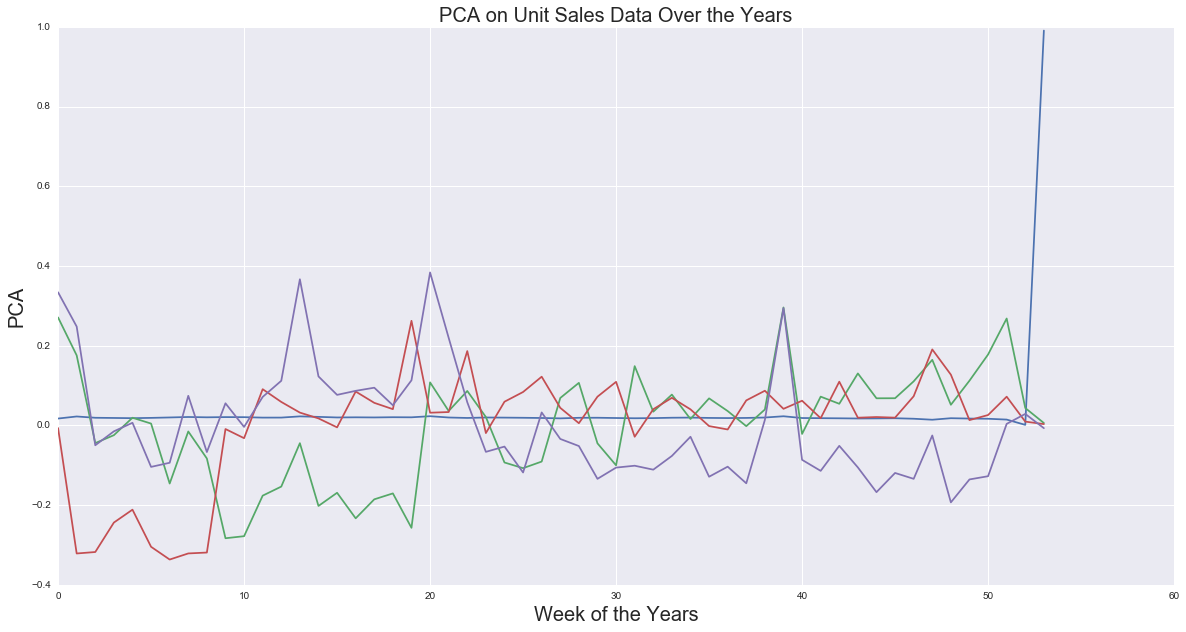

In [64]:
plt.figure(figsize=(20,10))
plt.plot(eig_vec_cov[:,0:4])
size=20
plt.xlabel('Week of the Years',size=size)
plt.ylabel('PCA', size=size)
plt.title('PCA on Unit Sales Data Over the Years', size=size)

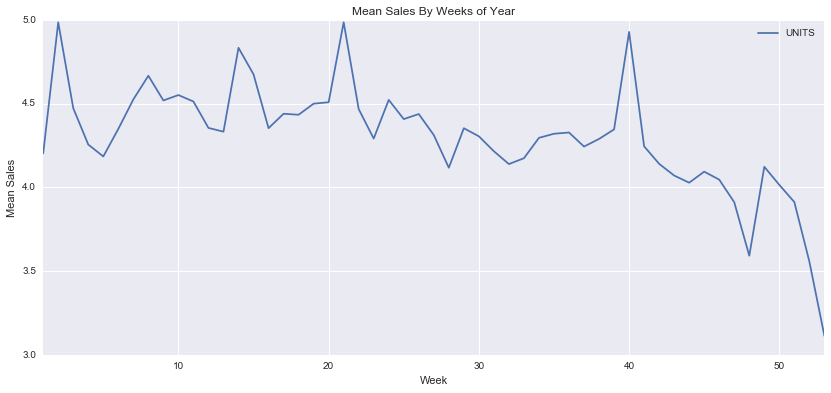

In [38]:
Sales_By_Weeks = df_drug_sales.groupby(['WeekOfYear']).mean()[['UNITS']]
Sales_By_Weeks.plot(figsize=(14, 6))
plt.xlabel('Week')
plt.ylabel('Mean Sales')
plt.title('Mean Sales By Weeks of Year')
plt.grid(True)
plt.show()

In [39]:
pd_covariance  = pd.DataFrame(cov_mat)
pd_eig_val = pd.DataFrame(eig_val_cov)
pd_eig_val.columns=[['Eigenvalues']]
pd.merge(pd_covariance, pd_eig_val, on=keys)

NameError: name 'keys' is not defined

In [ ]:
pd_covariance

In [ ]:
pd_eig_val